254
Found 254 files belonging to 2 classes.
Using 204 files for training.
Found 254 files belonging to 2 classes.
Using 50 files for validation.
['men', 'women']
Epoch 1/5
7/7 [==============================] - 8s 892ms/step - loss: 25.6564 - accuracy: 0.4265 - val_loss: 13.4266 - val_accuracy: 0.6200
Epoch 2/5
7/7 [==============================] - 6s 817ms/step - loss: 16.8962 - accuracy: 0.4804 - val_loss: 5.3682 - val_accuracy: 0.7800
Epoch 3/5
7/7 [==============================] - 6s 839ms/step - loss: 11.1755 - accuracy: 0.5686 - val_loss: 9.1416 - val_accuracy: 0.3800
Epoch 4/5
7/7 [==============================] - 6s 913ms/step - loss: 8.3117 - accuracy: 0.4853 - val_loss: 4.8766 - val_accuracy: 0.7400
Epoch 5/5
2/2 [==============================] - 1s 103ms/step - loss: 6.1498 - accuracy: 0.7400
Validation loss: 6.149820327758789, Validation accuracy: 0.7400000095367432


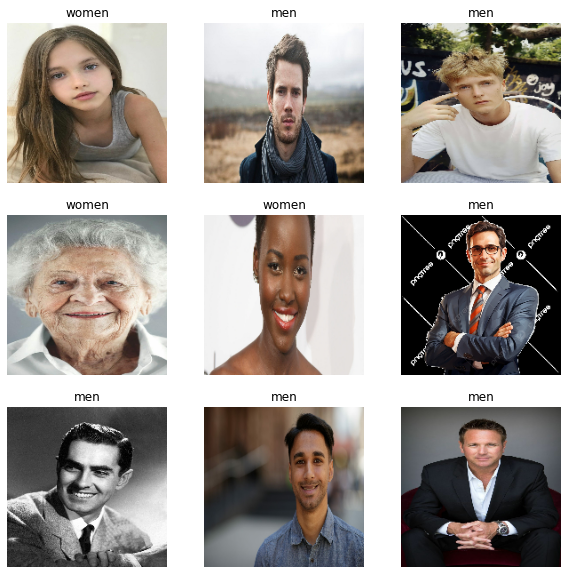

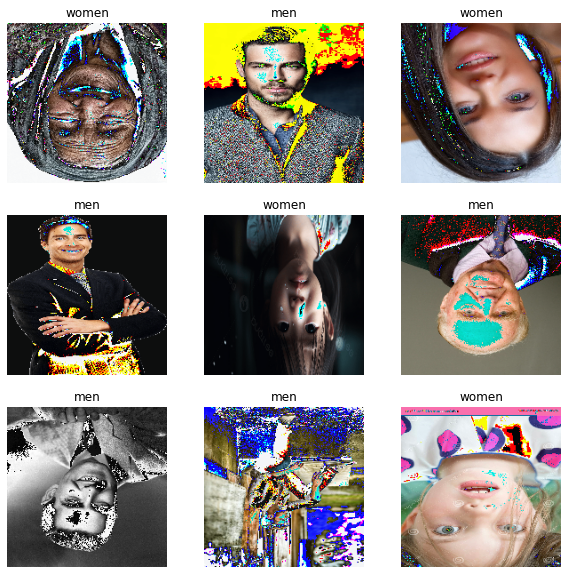

254
Found 254 files belonging to 2 classes.
Using 204 files for training.
Found 254 files belonging to 2 classes.
Using 50 files for validation.
['men', 'women']
Epoch 1/5
7/7 [==============================] - 8s 1s/step - loss: 27.5557 - accuracy: 0.4265 - val_loss: 7.1464 - val_accuracy: 0.6200
Epoch 2/5
7/7 [==============================] - 6s 847ms/step - loss: 11.6250 - accuracy: 0.6078 - val_loss: 11.8043 - val_accuracy: 0.3800
Epoch 3/5
7/7 [==============================] - 6s 899ms/step - loss: 8.5646 - accuracy: 0.5539 - val_loss: 5.4279 - val_accuracy: 0.6200
Epoch 4/5
7/7 [==============================] - 6s 882ms/step - loss: 6.6463 - accuracy: 0.5882 - val_loss: 5.0199 - val_accuracy: 0.7200
Epoch 5/5
2/2 [==============================] - 1s 119ms/step - loss: 6.1626 - accuracy: 0.4800
Validation loss: 6.1626410484313965, Validation accuracy: 0.47999998927116394


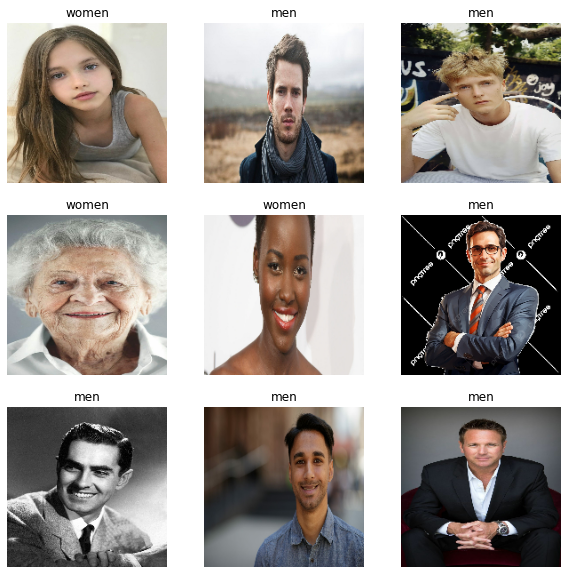

In [1]:
import cv2
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Path to dataset
import cv2
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Path to dataset
path_data = pathlib.Path('/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset')
image_count = len(list(path_data.glob('*/*')))
print(image_count)

# Parameters
batch_size = 32
img_height = 180
img_width = 180
num_classes = 7

# Load dataset with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    path_data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    path_data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

class_names = train_ds.class_names
print(class_names)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(0.2),

])

# Visualize some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Normalize datasets
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch to optimize data loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model definition (with dropout and added complexity)
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Class weights to handle imbalance
class_weight = {0: 1.0, 1: 1.5, 2: 2.0, 3: 1.2, 4: 1.0, 5: 1.8, 6: 1.5}

# Fit the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # Increased number of epochs
    class_weight=class_weight,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(normalized_val_ds)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

# Save the model
model.save('trained_face_expression_v2.h5')

# Plot predictions for sample images
plt.figure(figsize=(10, 10))
for images, labels in normalized_train_ds.take(1):
    predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy() * 255  # Convert back to 0-255 range
        plt.imshow(image.astype("uint8"))
        predicted_class = class_names[np.argmax(predictions[i])]
        plt.title(predicted_class)
        plt.axis("off")

plt.show()
image_count = len(list(path_data.glob('*/*')))
print(image_count)

# Parameters
batch_size = 32
img_height = 180
img_width = 180
num_classes = 7

# Load dataset with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    path_data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    path_data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

class_names = train_ds.class_names
print(class_names)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Visualize some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Normalize datasets
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x)), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch to optimize data loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model definition (with dropout and added complexity)
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Class weights to handle imbalance
class_weight = {0: 1.0, 1: 1.5, 2: 2.0, 3: 1.2, 4: 1.0, 5: 1.8, 6: 1.5}

# Fit the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # Increased number of epochs
    class_weight=class_weight,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(normalized_val_ds)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

# Save the model


In [ ]:
# Plot predictions for sample images
plt.figure(figsize=(10, 10))
for images, labels in normalized_train_ds.take(1):
    predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy() * 255  # Convert back to 0-255 range
        plt.imshow(image.astype("uint8"))
        predicted_class = class_names[np.argmax(predictions[i])]
        plt.title(predicted_class)
        plt.axis("off")

plt.show()